# BERT as Embedding 
____________________

## Task: Finding Semantic Textual Similarity

In [2]:
# Ignore all your warnings
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# Loading Libraries
import datetime
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
import pylab 
import scipy.stats as stats
from scipy.stats import boxcox

import re
import pickle

from tqdm import tqdm
import os
from wordcloud import WordCloud
from matplotlib_venn import venn2
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from textblob import TextBlob

import nltk
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
eng_stopwords = stopwords.words('english')
import gc
from bs4 import BeautifulSoup
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import tensorflow

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize, StandardScaler
from scipy import sparse as sp
from scipy.sparse import hstack

from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import minmax_scale
from sklearn.metrics.pairwise import cosine_similarity

from transformers import BertModel, BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
import torch

## Workflow

#### 1. Problem Statement and Dataset Description
#### 2. Dataset Loading
#### 3. Machine learning Formulation
#### 4. Exploratory Data Analyses
#### 5. Preprocessing 
#### 6. Feature engineering and Modeling (Finding Similarity)
#### 7. Results and Conclusion

.  .  .  .  .  .

# 1. Problem Statement

Given two paragraphs, quantify the degree of similarity between the two text-based on Semantic
similarity. Semantic Textual Similarity (STS) assesses the degree to which two sentences are
semantically equivalent to each other. The STS task is motivated by the observation that accurately
modelling the meaning similarity of sentences is a foundational language understanding problem
relevant to numerous applications including machine translation (MT), summarization, generation,
question-answering (QA), short answer grading, semantic search.

STS is the assessment of pairs of sentences according to their degree of semantic similarity. The task
involves producing real-valued similarity scores for sentence pairs. 

### About Dataset

* The data contains a pair of paragraphs. These text paragraphs are randomly sampled from a raw
dataset.
* Each pair of the sentence may or may not be semantically similar. The candidate is to
predict a value between 0-1 indicating a degree of similarity between the pair of text paras.

* 1 means highly similar

* 0 means highly dissimilar 

#### Note: The given dataset does not contain any label.

.  .  .  .  .  .

## 2. Dataset Loading

In [3]:
# Loading Dataset
data = pd.read_csv("Text_Similarity_Dataset.csv",delimiter=',')
data.sample(10)

,Unique_ID,text1,text2
2088,2088,china had role in yukos split-up china lent ru...,yahoo celebrates a decade online yahoo one of...
2582,2582,school tribute for tv host carson more than 1 ...,plaid mp s cottage arson claim a plaid cymru m...
18,18,mobile multimedia slow to catch on there is no...,text messages aid disaster recovery text messa...
3878,3878,wenger steps up row arsene wenger has stepped ...,bellamy under new fire newcastle boss graeme s...
1586,1586,sundance to honour foreign films international...,paraguay novel wins us book prize a novel set ...
2276,2276,wada will appeal against ruling the world anti...,uk athletics agrees new kit deal uk athletics ...
558,558,iranian mps threaten mobile deal turkey s bigg...,rank set to sell off film unit leisure group...
3685,3685,fears raised over ballet future fewer children...,consumer concern over rfid tags consumers are ...
1267,1267,tv calls after carroll error spurs boss martin...,parmalat sues 45 banks over crash parmalat has...
3214,3214,the year search became personal the odds are t...,kennedy begins pre-election tour liberal democ...


.  .  .  .  .  .

## 3. Machine learning Formulation

* The given dataset does not contain any label. Therefore, can be treated as an unsupervised learning problem.

* However, this does not imply that supervised techniques are not applicable.

#### So the task is to find the degree of similarity between the pair of text paras i.e predict a value between 0-1.

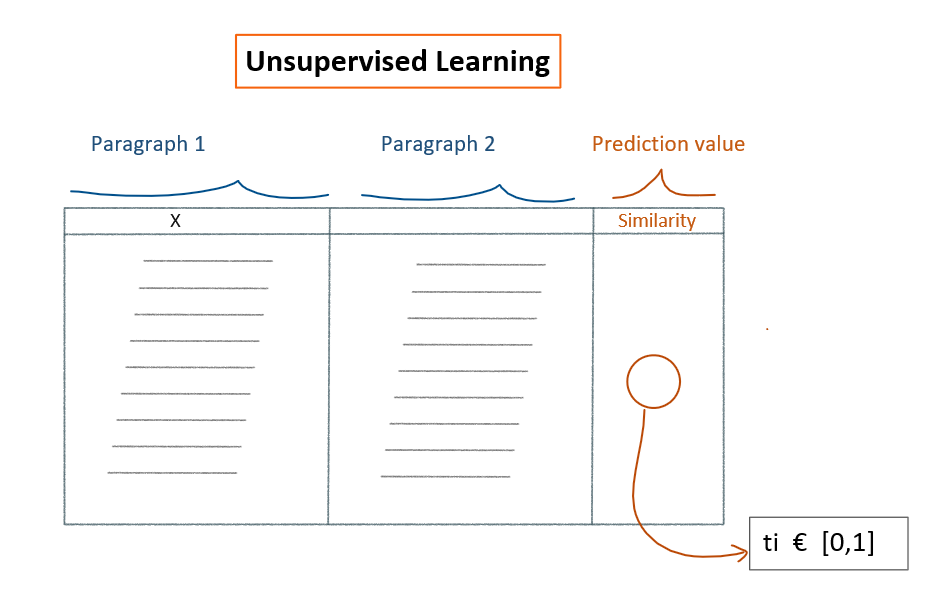

In [4]:
from IPython.display import Image
Image(filename='Capture.png')

## 3.1 Approaches to solve the Problem

### Approach 1: Using Avg Word2Vec of text1 and text2 and find similarity 

1. Find the word embeddings of each word and average it on total words of text.
2. Find Cosine Similarity between embeddings of text1 and text2.
3. Scale the Cosine Similarity result between [0,1] 

### Approach 2: Using Avg Tfidf Word2Vec of text1 and text2 and find similarity 
1. Fit TfIDF on combination of text1 and text2 and create dictionary of vocabulary and idf_scores
2. Find the word embeddings of each word and multiply the embedding of that word with its corresponding idf_score and average the embeddings of total words present in text.
3. Following above step find the embeddings of text1 and text2.
4. Find Cosine Similarity between embeddings of text1 and text2.
5. Scale the Cosine Similarity result between [0,1] 

### Approach 3:Using Spacy NLP pipeline to find similarity
1. Find the Similarity between embeddings of text1 and text2 using spacy NLP pipeline.
2. Scale the Similarity result between [0,1] 

### Approach 4: Using Bert pretrained model as feature extraction (pytorch framework GPU)
1. Format the text into desired format of Bert model.
2. Find the word 784 dim embeddings for each token and from the embedding of [cls] token. 
2. Average the embeddings of total tokens passed to bert model.
3. Following above step find the embeddings of text1 and text2.
4. Find Cosine Similarity between embeddings of text1 and text2.
5. Scale the Cosine Similarity result between [0,1] 


## 4. Exploratory Data Analyses

In [5]:
# Shape of Dataset
print(f"Shape of dataset: {data.shape}\n")

# Any Unique Values
print(f'Number of Duplicate values: {data.Unique_ID.duplicated().sum()}\n')

print(f" Any null Column{data.isnull().any()}")

Shape of dataset: (4023, 3)

Number of Duplicate values: 0

 Any null ColumnUnique_ID    False
text1        False
text2        False
dtype: bool


### 4.0 Utility Function

In [6]:
# Utility function to plot lineplot and distplot using seaborn
def plot_sns(data,feature,color='lightblue',title=None,subtitle=None):
    
    """   
    Utility function to plot lineplot and distplot using seaborn
    
    plot_sns(data,feature,color='lightblue',title=None,subtitle=None):
    
    data = data 
    feature = coulum name
    color = color of plot
    title = Either 'length' or 'number' based on which to plot. Otherwise by default='None'
    subtitle = Either 'train_df' or 'test_df'. Otherwise by default='None'  
    
    """    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 6))
    
    # line plot
    sns.lineplot(np.arange(len(data)),data,ax=ax1,color=color)    
    if title=='number':
        ax1.set(xlabel=f"Idx of {feature}", ylabel=f"Number of words in {feature}", title=f'Number of words in {feature} in {subtitle}\n')
    elif title=='length':
        ax1.set(xlabel=f"Idx of {feature}", ylabel=f"Length of {feature}", title=f'Length of {feature} in {subtitle}\n')   
    ax1.grid()

    # distribution plot
    sns.distplot(data,ax=ax2,color=color)
    if title=='number':
        ax2.set(xlabel=f"Idx of {feature}", ylabel=f"Number of words in {feature}", title=f'Number of words in {feature} in {subtitle}\n')
    elif title=='length':
        ax2.set(xlabel=f"Idx of {feature}", ylabel=f"Length of {feature}", title=f'Length of {feature} in {subtitle}\n')   
    ax2.grid()
    plt.show()

#=======================================================================================================================================================================================    
# Utility function to plot bar graph for both train and test using seaborn
def plot_bar(train_data,test_data,feature=None,x_label=None, y_label=None):
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 6))

    # for train_df
    sns.barplot(train_data,np.arange(len(train_data)),ax=ax1)
    ax1.set(xlabel=f"{x_label}", ylabel=f"{y_label} {feature}", title='train_df\n')
    ax1.grid()
    
    # for test_df
    sns.barplot(test_data,np.arange(len(test_data)),ax=ax2)
    ax2.set(xlabel=f"{x_label}", ylabel=f"{y_label} {feature}", title='test_df\n')
    ax2.grid()
    plt.show()
    
#=======================================================================================================================================================================================  
# Utility function to plot requency of most popular words
def word_frequency_plot(dataframe, title=None):
    list_of_all_words = []
    for sent in dataframe:
        list_of_all_words.extend(sent.split())

    top_50_words = pd.Series(list_of_all_words).value_counts()[:50]
    top_50_words_prob_dist = top_50_words.values/sum(top_50_words.values)

    #  plot of frequency of polpular words in train
    plt.figure(figsize=(16,7))
    sns.barplot(top_50_words.index, top_50_words_prob_dist)
    plt.xlabel("words")
    plt.ylabel("frequency")
    plt.title(f"Frequency of most popular words {title}\n")
    plt.xticks(rotation=70)
    plt.grid()
    plt.show()

#=======================================================================================================================================================================================
# Utility function to check if feature or variable follows Normal distribution using Q-Q Plot   
def q_q_plot(train_data, test_data, feature_name=None):
    """
    # code refer: https://stackoverflow.com/a/13865874
    """
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
    
    measurements = train_data
    stats.probplot(measurements, dist="norm", plot=ax1)
    ax1.set(title=f'train : Q-Q Plot for {feature_name} \n')

    measurements = test_data
    stats.probplot(measurements, dist="norm", plot=ax2)
    ax2.set(title=f'test : Q-Q Plot for {feature_name} \n')
    plt.show()
        
#=======================================================================================================================================================================================    
# Utility function for box plot
def box_plot(data, feature_name=None):
    
    # for train data
    plt.figure(figsize=(26,4))
    sns.violinplot(data,color='darkred')
    plt.title(f'Train : violinplot Plot for {feature_name} \n')
    plt.xlabel(f"{feature_name}")
    plt.ylabel(f"Distribution")   
    plt.grid()
    plt.show()
    


## 4.1. EDA: text1

### 4.1.1. Length of text1 

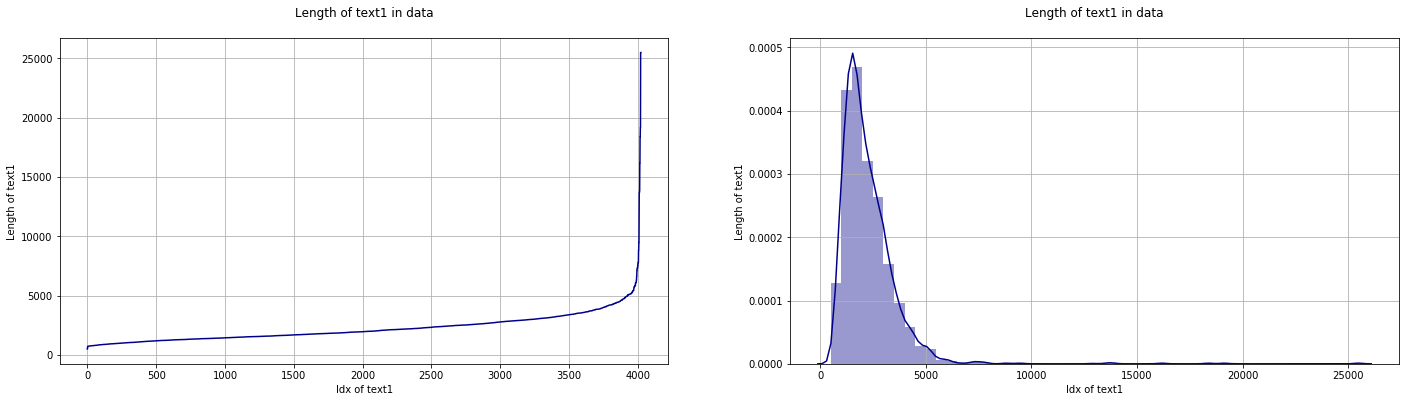

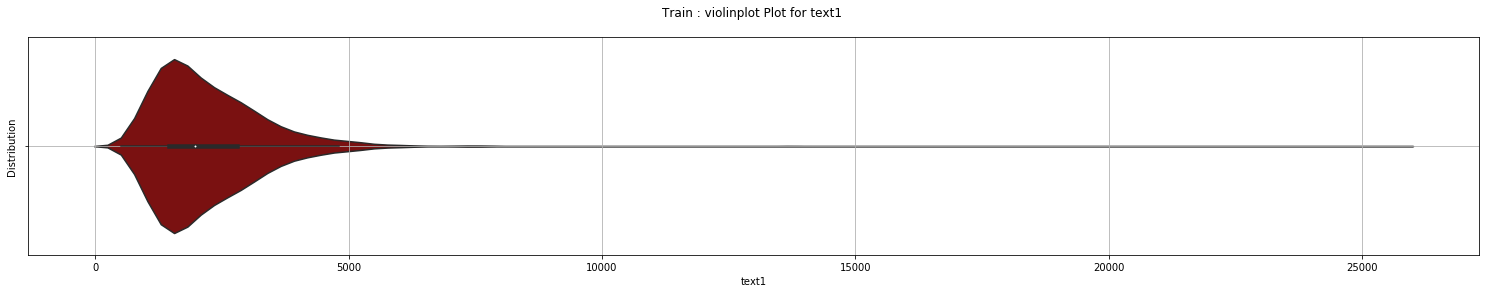

In [7]:
# Length of text1 
data['len_text1'] = data['text1'].apply(lambda x: len(x))

# plot 
plot_sns(sorted(data['len_text1']),"text1",color='darkblue',title='length',subtitle='data')

# Box plot of Length of question_title in train and test
box_plot(sorted(data['len_text1']), "text1")

#### Observation:

* Maximum length of text1 is upto 25000.
* Distribution is highly skewed toward right( looks like it following log normal distribution)

### 4.1.2. Number of words in text 1

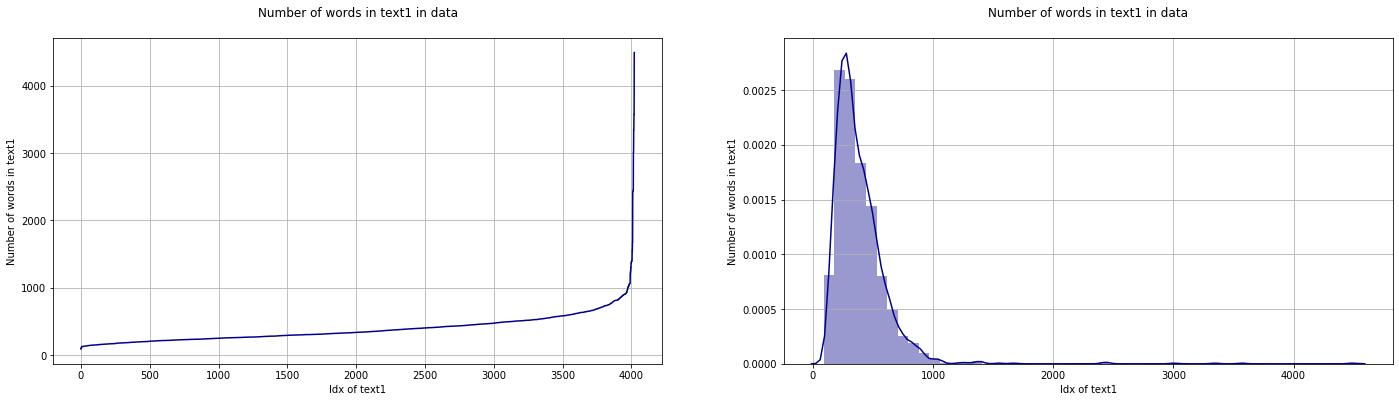

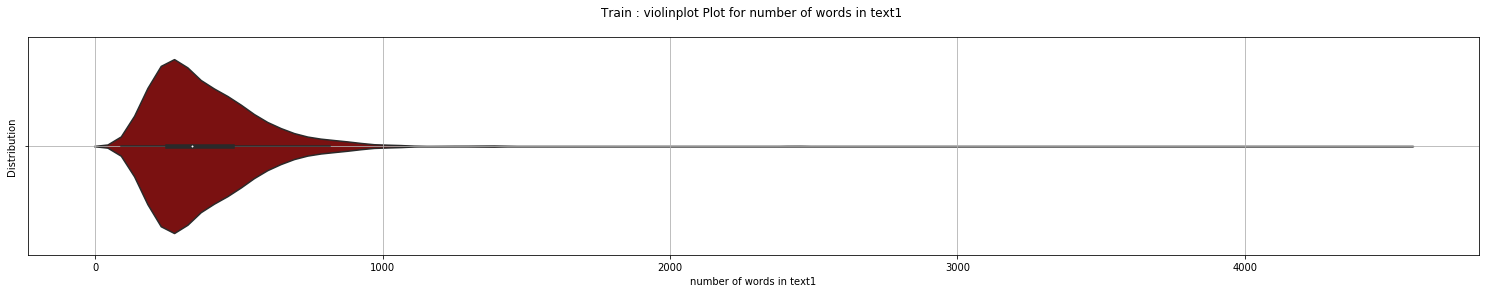

In [8]:
# Number of words of text1 
data['n_text1'] = data['text1'].apply(lambda x: len(x.split()))

# plot 
plot_sns(sorted(data['n_text1']),"text1",color='darkblue',title='number',subtitle='data')

# Box plot of Length of question_title in train and test
box_plot(sorted(data['n_text1']), "number of words in text1")

#### Observation:

* Maximum number of words in text1 is upto 4500 words.
* Distribution is highly skewed toward right. 

### 4.1.3. WordCloud of text1

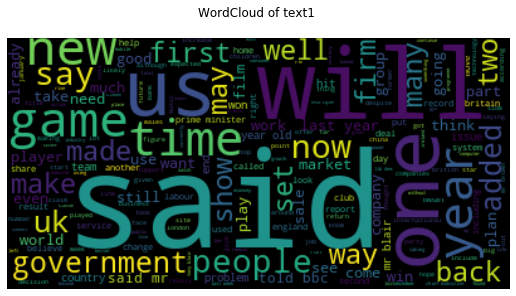

In [9]:
# refer: https://www.datacamp.com/community/tutorials/wordcloud-python

# For train_df
text_train = " ".join(word for word in data['text1'])

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text_train)

# Display the generated image:
plt.figure(figsize=(9,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("WordCloud of text1 \n")
plt.axis("off")
plt.show()


## 4.2. EDA: text2

### 4.2.1. Length of text2

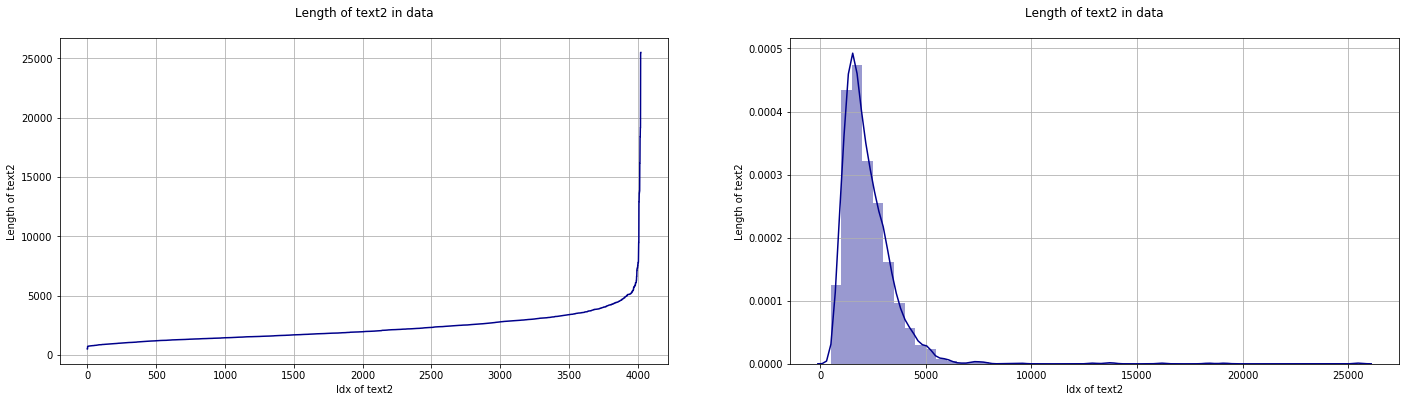

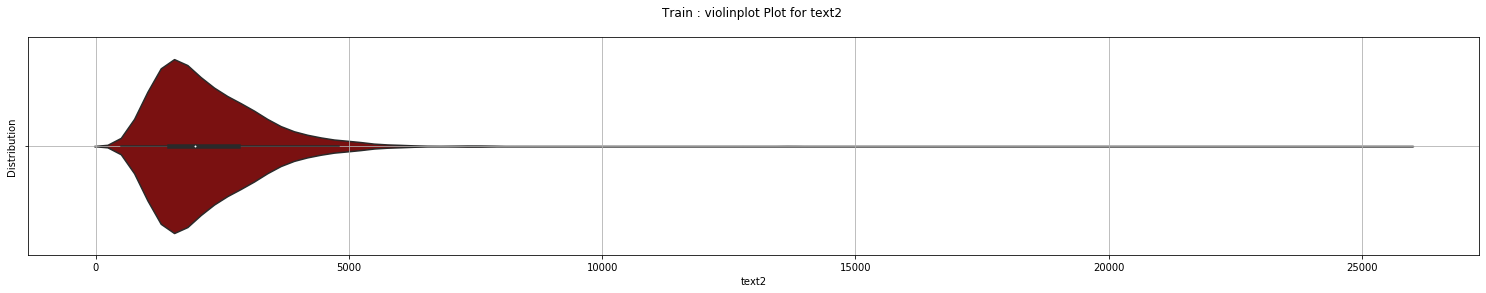

In [10]:
# Length of text1 
data['len_text2'] = data['text2'].apply(lambda x: len(x))

# plot 
plot_sns(sorted(data['len_text2']),"text2",color='darkblue',title='length',subtitle='data')

# Box plot of Length of question_title in train and test
box_plot(sorted(data['len_text2']), "text2")

### 4.2.2. Number of words in text2

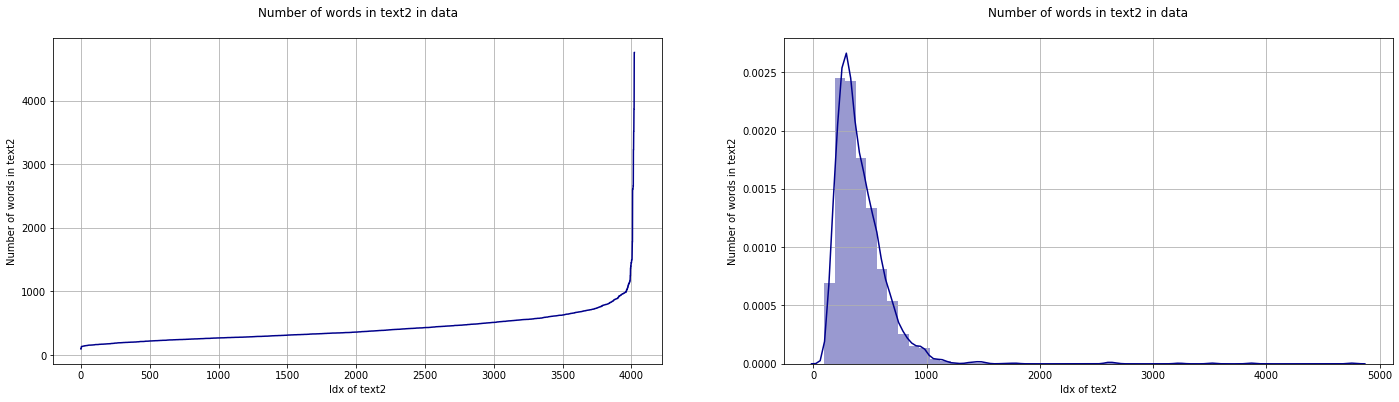

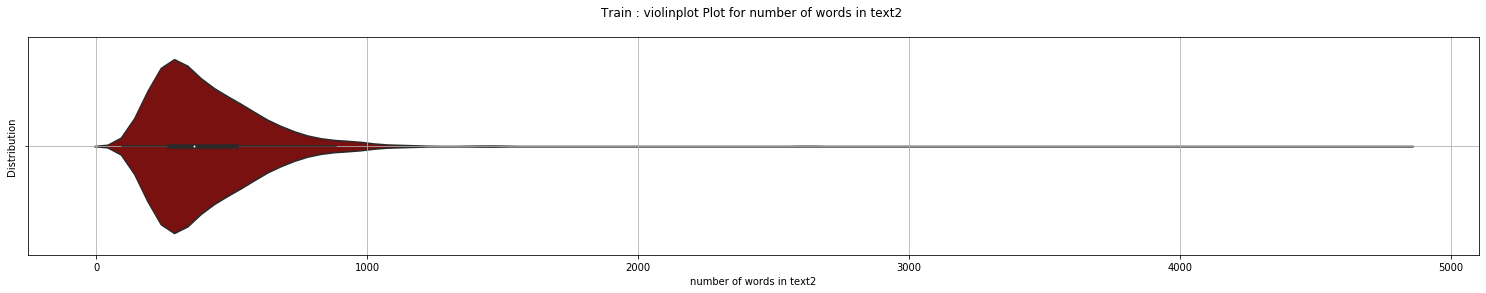

In [11]:
# Number of words of text1 
data['n_text2'] = data['text2'].apply(lambda x: len(x.split(" ")))

# plot 
plot_sns(sorted(data['n_text2']),"text2",color='darkblue',title='number',subtitle='data')

# Box plot of Length of question_title in train and test
box_plot(sorted(data['n_text2']), "number of words in text2")

#### Observation:

Observation is almost same as text1 observations.

### 4.2.3. WordCloud of text2

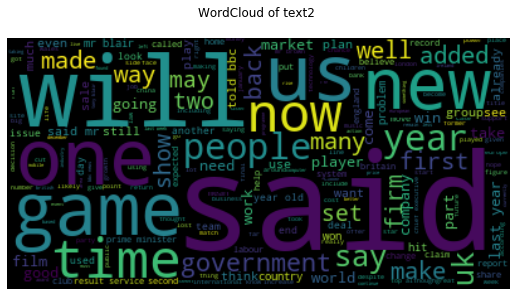

In [12]:
# refer: https://www.datacamp.com/community/tutorials/wordcloud-python

# For train_df
text_train = " ".join(word for word in data['text2'])

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text_train)

# Display the generated image:
plt.figure(figsize=(9,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("WordCloud of text2 \n")
plt.axis("off")
plt.show()


## 5. Preprocessing

#### Utility Function

In [13]:
# Preprocessing Functions
# credit : https://www.kaggle.com/urvishp80/quest-encoding-ensemble

mispell_dict = {"aren't" : "are not","can't" : "cannot","couldn't" : "could not","couldnt" : "could not","didn't" : "did not","doesn't" : "does not",
                "doesnt" : "does not","don't" : "do not","hadn't" : "had not","hasn't" : "has not","haven't" : "have not","havent" : "have not",
                "he'd" : "he would","he'll" : "he will","he's" : "he is","i'd" : "I would","i'd" : "I had","i'll" : "I will","i'm" : "I am",
                "isn't" : "is not","it's" : "it is","it'll":"it will","i've" : "I have","let's" : "let us","mightn't" : "might not",
                "mustn't" : "must not","shan't" : "shall not","she'd" : "she would","she'll" : "she will","she's" : "she is","shouldn't" : "should not",
                "shouldnt" : "should not","that's" : "that is","thats" : "that is","there's" : "there is","theres" : "there is","they'd" : "they would",
                "they'll" : "they will","they're" : "they are","theyre":  "they are","they've" : "they have","we'd" : "we would","we're" : "we are",
                "weren't" : "were not","we've" : "we have","what'll" : "what will","what're" : "what are","what's" : "what is","what've" : "what have",
                "where's" : "where is","who'd" : "who would","who'll" : "who will","who're" : "who are","who's" : "who is","who've" : "who have",
                "won't" : "will not","wouldn't" : "would not","you'd" : "you would","you'll" : "you will","you're" : "you are","you've" : "you have",
                "'re": " are","wasn't": "was not","we'll":" will","didn't": "did not","tryin'":"trying"}


imp_keywords = ("R", "r", "C","c", "os", "OS")


# Counting the numeric feature and removing it
def count_digits_and_remove(text):
    """
    counting the number of occurance of digit
    
    return : text , (n_total_digit, n_2_digit, n_3_digit, n_4_digit, n_5_plus_digit)
    
    n_total_digit  : Total occurance of numeric feature
    n_2_digit      : Number of time 2 digit numeric feature occur
    n_2_digit      : Number of time 3 digit numeric feature occur
    n_2_digit      : Number of time 4 digit numeric feature occur
    n_5_plus_digit : Number of time more than 4 digit numeric feature occur
    
    """
    digits = re.findall(r'[0-9]+',text)

    n_total_digit = []
    n_2_digit = []
    n_3_digit = []
    n_4_digit = []
    n_5_plus_digit = []

    n_total_digit.append(len(digits))
    for digit in digits:
        if len(digit)==2:
            n_2_digit.append(digit)

        elif len(digit)==3:
            n_3_digit.append(digit)

        elif len(digit)==4:
            n_4_digit.append(digit)

        elif len(digit)>4:
            n_5_plus_digit.append(digit)
    
    # remove all the numbers
    text = re.sub(r'[0-9]+'," ",text)
            
    return text , (len(n_total_digit), len(n_2_digit), len(n_3_digit), len(n_4_digit), len(n_5_plus_digit))

#======================================================================================================================================
# Counting number of non_alpha_numeric character and removing all the special character words
def count_non_alpha_numeric_and_remove(text):  
    """ Counting number of non_alpha_numeric character(for programinng context) """
    
    # finding all the all the non_alpha_numeric char
    n_special_char = (re.findall(r"[^A-Za-z0-9 :]", text))
    
    # removing it.
    text = re.sub(r"[^A-Za-z0-9]", " ",text)
    
    return text ,len(n_special_char)

#======================================================================================================================================
# Counting the number of all capital word(maybe it would be corelated with labels) and coverting into lower string character
def count_all_cap_words_and_lower_it(text):
    
    """Finding the number of all capital word and lower it"""

    # Find all the capital words
    n_all_capital_words = (re.findall(pattern = r'([A-Z]([A-Z])+)',string=text))
    
    # converting into string into lower char string
    text = text.lower()
    
    return text , len(n_all_capital_words)

#======================================================================================================================================
def _get_mispell(mispell_dict):
    mispell_re = re.compile('(%s)' % '|'.join(mispell_dict.keys()))
    return mispell_dict, mispell_re

def replace_typical_misspell(text):
    
    """De-Concatenation of words and correction of misspelled words"""
    mispellings, mispellings_re = _get_mispell(mispell_dict)

    def replace(match):
        return mispellings[match.group(0)]

    return mispellings_re.sub(replace, text)

#======================================================================================================================================

# Return the number of links and text without html tags 
# Also return the counts of 'number of lines'  and remove it
def strip_html(text):
    """ 
    Return the number of links and clean text (without html tags) 
    Also return the counts of 'number of lines'  and remove it
    
    """
    # finding http links using regex and counting it and remove it
    n_links = (re.findall(r'http[s]?://\S+',text))
    text = re.sub(r'http[s]?://\S+'," ",text)
    
    # finding number of lines using regex and counting it and remove it
    n_lines = re.findall(r'\n',text)
    text = re.sub(r'\n', " ",text)
    
    return  text, len(n_links) , len(n_lines)

#======================================================================================================================================
# function to remove all the stopwords and words having lengths less than 3
def remove_stop_words_and_punc(text) :
    
    """ 
    Remove all the stopwords 
    Remove all the words whose length is less than 3 and not belong to important keywords(e.g. 'C','R','OS' etc)
    
    """
    # removing the words from the stop words list: 'no', 'nor', 'not'
    stops = set(stopwords.words("english"))
    stops.remove('no')
    stops.remove('nor')
    stops.remove('not')
    
    text= text.split()
    text = [w for w in text if not w in stops]    
    
    # Removing the words having length less than 3 and not the imp_keyword
    clean_text = []
    for word in text:
        if word not in imp_keywords and len(word)<3:
            pass
        else:
            clean_text.append(word)
          
        
    clean_text = " ".join(clean_text)
    return(clean_text)

#======================================================================================================================================
# function for stemming of words in text
def stem(text):
    stemmer = PorterStemmer()
    result = " ".join([ stemmer.stem(word) for word in text.split(" ")])
    return result   

In [14]:
#======================================================================================================================================
# Final text cleaning funtion  
def clean_text(text, extra_features=True, strip_html_fn=True, count_all_cap_words_and_lower_it_fn=True, replace_typical_misspell_fn=True, count_digits_and_remove_fn=True,
               count_non_alpha_numeric_and_remove_fn=True, remove_stop_words_and_punc_fn=True,stem_fn=True):
    """
    This function sequentially execute all the cleaning and preprocessing function and finaly gives cleaned text.
    Input: Boolean values of extra_features, strip_html, count_all_cap_words_and_lower_it, replace_typical_misspell, count_non_alpha_numeric_and_remove, remove_stop_words_and_punc, stem
            (by default all the input values = True)
    
    return: clean text
    
    """
    if strip_html_fn:
        # remove html tags
        clean_text, n_links, n_lines = strip_html(text)
    
    if count_all_cap_words_and_lower_it_fn:
        # Find all the capital words and covert all chars of text into lower char string
        clean_text, n_all_capital_words= count_all_cap_words_and_lower_it(clean_text)

    if replace_typical_misspell_fn:       
        # de-concatenation of words
        clean_text = replace_typical_misspell(clean_text)
    
    if count_digits_and_remove_fn:
        # count the numbers and remove it
        clean_text, (n_total_digit, n_2_digit, n_3_digit, n_4_digit, n_5_plus_digit) = count_digits_and_remove(clean_text)
    
    if count_non_alpha_numeric_and_remove_fn:
        # Count the number of non alpha numeric character and remove it
        clean_text, n_non_alpha_char = count_non_alpha_numeric_and_remove(clean_text)
    
    if remove_stop_words_and_punc_fn:
        # removing Stopwords and the words length less than 3(As these words mostly tend to redundant words) excpect 'C' and 'R'and 'OS' <-- programing keywords
        clean_text = remove_stop_words_and_punc(clean_text)
    
    if stem_fn:
        # stemming ( use only for BOW or TFIDF represention. Not effective for word embedding like w2v or glove)
        clean_text = stem(clean_text)
    
    # return extra_features 
    if extra_features:
        return clean_text, (n_links, n_lines, n_all_capital_words, n_non_alpha_char, n_total_digit, n_2_digit, n_3_digit, n_4_digit, n_5_plus_digit)
    
    else:
        return clean_text

#======================================================================================================================================================    
#======================================================================================================================================================    
# This function is only for  word embedding pre processing
# This function will take dataframe and return cleaned dataframe (This fincion will only be used for BOW nd TFIDF representaion)
def clean_data_for_embeding(dataframe ):
    
    """
    This function will take dataframe and return cleaned dataframe along with extra features.
    
    Input: dataframe which need to preprocess only for embeddings words
    Return: clean dataframe 
    
    """
    cleaned_data = []
    
    for i in tqdm(range(dataframe.shape[0])):

        text = dataframe.iloc[i]
        
        cleaned_text = clean_text(text,extra_features= False, stem_fn=False) # There is no need of extra_features to calculate again as it is already calculated
        cleaned_data.append(cleaned_text)
      
    return cleaned_data

### 5.0. Preprocessing for word embedding (without stemming)

#### Preprocessing utility function for word embedding (without stemming)

Only minor change in this function and above preprocessing function is this statement:

     "clean_text(text,extra_features= False, stem_fn=False)" at line 19

### 5.1. Preprocessing: text1

In [15]:
clean_text_1_for_embedding = clean_data_for_embeding(data['text1'])
data['clean_text1_for_embedding'] = clean_text_1_for_embedding

100%|████████████████████████████████████████████████████████████████████████████| 4023/4023 [00:02<00:00, 1436.51it/s]


#### Sample

In [16]:
# Sample preproceesing
i=15

print(f"Before preproceesing: \n{'-'*20}\n{data['text1'][i]}\n")
print(f"After preproceesing: \n{'-'*20}\n{data['clean_text1_for_embedding'][i]}")

Before preproceesing: 
--------------------
bond game fails to shake or stir for gaming fans  the word goldeneye evokes excited memories not only of the james bond revival flick of 1995  but also the classic shoot-em-up that accompanied it and left n64 owners glued to their consoles for many an hour.  adopting that hallowed title somewhat backfires on this new game  for it fails to deliver on the promise of its name and struggles to generate the original s massive sense of fun. this however is not a sequel  nor does it relate to the goldeneye film. you are the eponymous renegade spy  an agent who deserts to the bond world s extensive ranks of criminal masterminds  after being deemed too brutal for mi6. your new commander-in-chief is the portly auric goldfinger  last seen in 1964  but happily running around bent on world domination. with a determination to justify its name which is even less convincing than that of tina turner s similarly-titled theme song  the game literally gives the 

### 5.1.1. Number of words in clean_text1_for_embedding

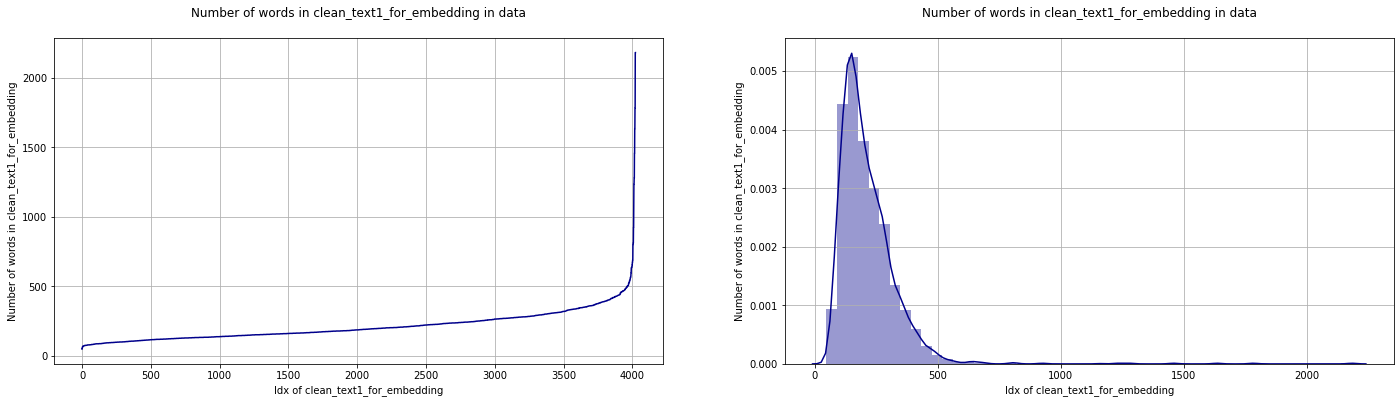

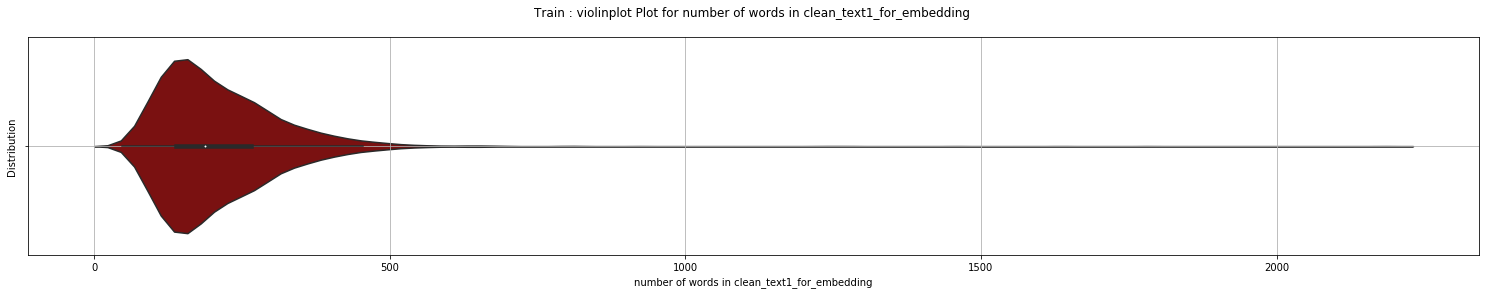

In [17]:
# Number of words of text1 
data['n_word_clean_text1_for_embedding'] = data['clean_text1_for_embedding'].apply(lambda x: len(x.split()))

# plot 
plot_sns(sorted(data['n_word_clean_text1_for_embedding']),"clean_text1_for_embedding",color='darkblue',title='number',subtitle='data')

# Box plot of Length of question_title in train and test
box_plot(sorted(data['n_word_clean_text1_for_embedding']), "number of words in clean_text1_for_embedding")

### 5.1.2.  Distribution of number of words of text1 text before v/s after preprocessing

1: Plot for text1


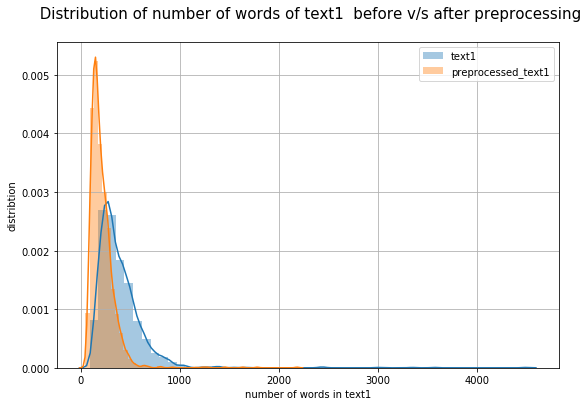

In [18]:
text_features_column = ['text1']

for idx,column in enumerate(text_features_column):
    
    # Calculating the length of text before and after preprocessing
    len_after_cleaning = data[f'clean_{column}_for_embedding'].apply(lambda x : len(x.split()))
    len_before_cleaning = data[f'{column}'].apply(lambda x : len(x.split()))
    
    # ploting
    print( f"{idx+1}: Plot for {column}")
    plt.figure(figsize=(9,6))
    sns.distplot(len_before_cleaning, label=f'{column}')
    sns.distplot(len_after_cleaning, label=f'preprocessed_{column}')
    plt.title(f" Distribution of number of words of {column}  before v/s after preprocessing\n",fontsize=15)
    plt.ylabel("distribtion")
    plt.xlabel(f"number of words in {column}")
    plt.legend()
    plt.grid()
    plt.show()

#### Observation

* Preproceesing has reduced the large amount of number of words making distribution more symmetrical but it is still higly skewed towards right.
* We can see from above disribution that most of the text has less than 500 number of words. ( we can use 500 tokens as max_len in BERT Embeddings) 

### 5.2. Preprocessing: text2

In [22]:
clean_text_2_for_embedding = clean_data_for_embeding(data['text2'])
data['clean_text2_for_embedding'] = clean_text_2_for_embedding

100%|████████████████████████████████████████████████████████████████████████████| 4023/4023 [00:02<00:00, 1357.43it/s]


#### Sample 

In [23]:
# Sample preproceesing
i=15

print(f"Before preproceesing: \n{'-'*20}\n{data['text2'][i]}")
print(f"\nAfter preproceesing: \n{'-'*20}\n{data['clean_text2_for_embedding'][i]}")

Before preproceesing: 
--------------------
mobile multimedia slow to catch on there is no doubt that mobile phones sporting cameras and colour screens are hugely popular. consumers swapping old phones for slinkier  dinkier versions are thought to be responsible for a 26% increase in the number of phones sold during the third quarter of 2004  according to analysts gartner more than 167 million handsets were sold between july and september 2004  a period that  according to gartner analyst carolina milanesi is  seldom strong . but although consumers have mobiles that can take and send snaps  sounds and video clips few  so far  are taking the chance to do so.  in fact  the numbers of people not taking and sending pictures  audio and video is growing. figures gathered by continental research shows that 36% of british camera phone users have never sent a multimedia message (mms)  up from 7% in 2003. this is despite the fact that  during the same period  the numbers of camera phones in the u

### 5.2.1. Number of words in clean_text2_for_embedding

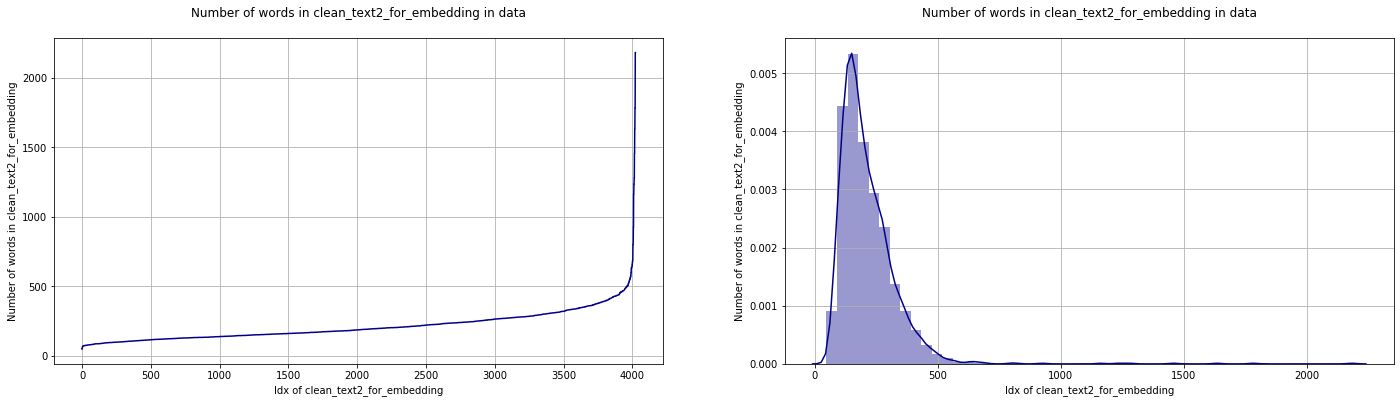

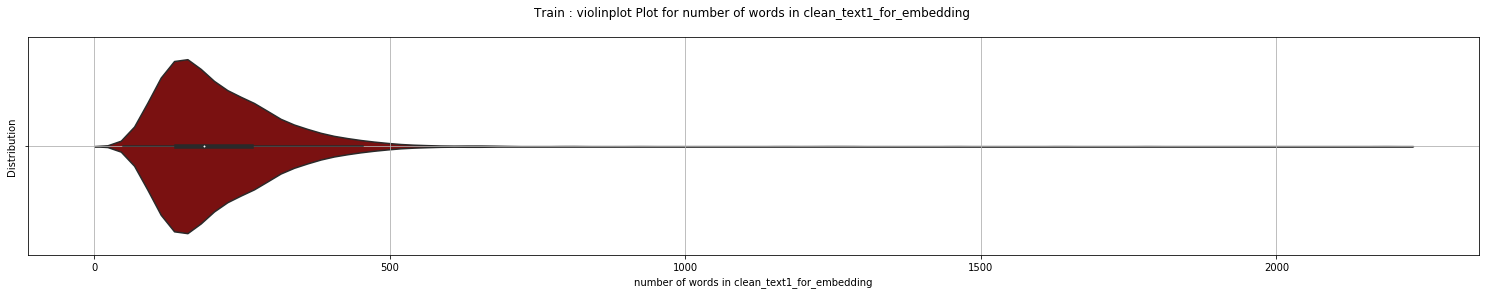

In [24]:
# Number of words of text1 
data['n_word_clean_text2_for_embedding'] = data['clean_text2_for_embedding'].apply(lambda x: len(x.split()))

# plot 
plot_sns(sorted(data['n_word_clean_text2_for_embedding']),"clean_text2_for_embedding",color='darkblue',title='number',subtitle='data')

# Box plot of Length of question_title in train and test
box_plot(sorted(data['n_word_clean_text2_for_embedding']), "number of words in clean_text1_for_embedding")

#### Observation

* Preproceesing has reduced the large amount of number of words making distribution more symmetrical but it is still higly skewed towards right.
* We can see from above disribution that most of the text has less than 500 number of words. ( we can use 500 tokens as max_len in BERT Embeddings) 

### 5.2.2.  Distribution of number of words of text1 text before v/s after preprocessing


1: Plot for text2


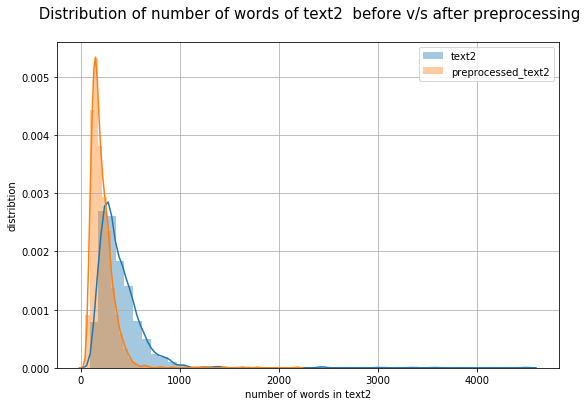

In [25]:
text_features_column = ['text2']

for idx,column in enumerate(text_features_column):
    
    # Calculating the length of text before and after preprocessing
    len_after_cleaning = data[f'clean_{column}_for_embedding'].apply(lambda x : len(x.split()))
    len_before_cleaning = data[f'{column}'].apply(lambda x : len(x.split()))
    
    # ploting
    print( f"{idx+1}: Plot for {column}")
    plt.figure(figsize=(9,6))
    sns.distplot(len_before_cleaning, label=f'{column}')
    sns.distplot(len_after_cleaning, label=f'preprocessed_{column}')
    plt.title(f" Distribution of number of words of {column}  before v/s after preprocessing\n",fontsize=15)
    plt.ylabel("distribtion")
    plt.xlabel(f"number of words in {column}")
    plt.legend()
    plt.grid()
    plt.show()

# 6. Feature Engineering and Modeling (Finding Similarity)

### Vector Representation of text

Using count vectoriser and tfidf vectoriser directly make vocab size too large and might not good as well. Therefore I am skipping it. 

#### 6.1. W2V Representation
#### 6.2. Tf-idf W2V Representation
#### 6.3. Using Bert Embedding

* Note: For word Embedding we have to preprocess the text again to remove stemming as it impact the sentiment of word in Embedding badly.

## 6.1. Approach 1: W2V Representation


#### Refer: https://www.kaggle.com/phoenix9032/quest-preprocessing-data-for-embedding

In [26]:
from gensim.models import KeyedVectors

news_path = 'crawl-300d-2M.vec'
embeddings_index = KeyedVectors.load_word2vec_format(news_path, binary=False)

In [27]:
## Building vocubulary from our Quest Data
def build_vocab(sentences, verbose =  True):
    """
    :param sentences: list of list of words
    :return: dictionary of words and their count
    """
    vocab = {}
    for sentence in tqdm(sentences, disable = (not verbose)):
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

#=========================================================================================================
import operator 
## This is a common function to check coverage between our quest data and the word embedding
def check_coverage(vocab,embeddings_index):
    a = {}
    oov = {}
    k = 0
    i = 0
    for word in tqdm(vocab):
        try:
            a[word] = embeddings_index[word]
            k += vocab[word]
        except:

            oov[word] = vocab[word]
            i += vocab[word]
            pass

    print('Found embeddings for {:.2%} of vocab'.format(len(a) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(k / (k + i)))
    sorted_x = sorted(oov.items(), key=operator.itemgetter(1))[::-1]

    return sorted_x

### 6.1.1. Check Coverage for clean_text1_for_embedding

In [28]:
##Apply the vocab function to get the words and the corresponding counts
sentences = data["clean_text1_for_embedding"].apply(lambda x: x.split()).values
vocab = build_vocab(sentences)

print(f"\nFor clean_text1_for_embedding: \n{'-'*40}")
oov = check_coverage(vocab,embeddings_index)

## List 10 out of vocabulary word
print(f"\nTop 10 out of vocabulary word: \n{'-'*30}")
oov[:10]

100%|███████████████████████████████████████████████████████████████████████████| 4023/4023 [00:00<00:00, 31648.56it/s]



For clean_text1_for_embedding: 
----------------------------------------


100%|████████████████████████████████████████████████████████████████████████| 27541/27541 [00:00<00:00, 451080.21it/s]


Found embeddings for 89.70% of vocab
Found embeddings for  98.27% of all text

Top 10 out of vocabulary word: 
------------------------------


[('yukos', 323),
 ('blunkett', 189),
 ('gazprom', 123),
 ('kenteris', 114),
 ('iaaf', 111),
 ('boerse', 110),
 ('rosneft', 103),
 ('ebbers', 101),
 ('yugansk', 101),
 ('thanou', 99)]

### 6.1.2. Check Coverage for clean_text2_for_embedding

In [29]:
##Apply the vocab function to get the words and the corresponding counts
sentences = data["clean_text2_for_embedding"].apply(lambda x: x.split()).values
vocab = build_vocab(sentences)

print(f"\nFor clean_text2_for_embedding: \n{'-'*40}")
oov = check_coverage(vocab,embeddings_index)

## List 10 out of vocabulary word
print(f"\nTop 10 out of vocabulary word: \n{'-'*30}")
oov[:10]

100%|███████████████████████████████████████████████████████████████████████████| 4023/4023 [00:00<00:00, 31157.84it/s]



For clean_text2_for_embedding: 
----------------------------------------


100%|████████████████████████████████████████████████████████████████████████| 27530/27530 [00:00<00:00, 483533.24it/s]


Found embeddings for 89.71% of vocab
Found embeddings for  98.25% of all text

Top 10 out of vocabulary word: 
------------------------------


[('yukos', 337),
 ('blunkett', 198),
 ('boerse', 128),
 ('gazprom', 117),
 ('iaaf', 108),
 ('rosneft', 108),
 ('kenteris', 107),
 ('ebbers', 106),
 ('yugansk', 100),
 ('thanou', 93)]

### 6.1.3. Creating AVG W2V array

In [30]:
# Function to convert text into avg W2V
def avg_w2v_of_text(text):
    
    avg_w2v_sent = np.zeros(300)    
    for word in text.split():
        
        try:
            avg_w2v_sent += embeddings_index.word_vec(word)
        except:
            pass
            
    avg_w2v_sent = avg_w2v_sent/len(text.split())
    return avg_w2v_sent

In [64]:
# For text1
cleaned_text1_avg_w2v =  data['clean_text1_for_embedding'].apply(lambda x: avg_w2v_of_text(x))

# For text2
cleaned_text2_avg_w2v =  data['clean_text2_for_embedding'].apply(lambda x: avg_w2v_of_text(x))

### 6.1.4 Finding Similarity using W2V Representation

In [65]:
# Finding Similarity using pair wise distance
similarity_score_w2v=[]
for i in range(data.shape[0]):
       similarity_score_w2v.append(cosine_similarity([cleaned_text1_avg_w2v[i]],[cleaned_text2_avg_w2v[i]])[0][0])


# Scaling the similarity between [0-1]
similarity_score_w2v = minmax_scale(similarity_score_w2v, feature_range=(0, 1))

# Round off upto 2 decimal
similarity_score_w2v = np.round(similarity_score_w2v,decimals=3)

In [71]:
# Checking some similarity text
print(f"Index where similarity bestween text1 and text2 is greater than 0.9: {np.where(similarity_score_w2v>0.99)[0]}")

print(f"Similarity Score of those index: {similarity_score_w2v[np.where(similarity_score_w2v > 0.99)]}")

Index where similarity bestween text1 and text2 is greater than 0.9: [3403]
Similarity Score of those index: [1.]


In [72]:
# Sample of text where similarity score is greater than 0.99
i = 3403
print("Sample of text where similarity score is greater than 0.9\n\n")
print(f" text1: \n{'-'*7}\n{data.iloc[i].text1}\n")
print(f" text2: \n{'-'*7}\n{data.iloc[i].text2}\n")

Sample of text where similarity score is greater than 0.9


 text1: 
-------
holmes starts 2005 with gb events kelly holmes will start 2005 with a series of races in britain.  holmes will make her first track appearance on home soil since winning double olympic gold in january s norwich union international in glasgow. she will also run in the grand prix in birmingham in february and may defend her indoor aaa 800m title in sheffield earlier that month.  i am still competitive and still want to win   she said.  i m an athlete and i can t wait to get back on the track.  she added:  these events are also a great opportunity to thank the british public for the enormous levels of support they have given me from the moment i stepped off that plane from greece.  the glasgow meeting will see holmes compete over 1500m in a five-way match against sweden  france  russia and italy.

 text2: 
-------
holmes starts 2005 with gb events kelly holmes will start 2005 with a series of races in britain.  h

## 6.2.  Approach 2: Tf-idf W2V Representation


In [35]:
def tfidf_w2v_of_dataframe(dataframe_text1, dataframe_text2):
    
    model = TfidfVectorizer()
    model.fit(dataframe_text1 + dataframe_text2)

    # we are converting a dictionary with word as a key, and the idf as a value
    dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
    
    # avg tfidf w2v conversion for text1
    avg_tfidf_w2v_text1 = []
    for i in tqdm(range(dataframe_text1.shape[0])):
        
        text = dataframe_text1.iloc[i] 
        avg_tfidf_w2v_sent = np.zeros(300)       
        len_of_text = len(text.split())
        weighted_sum =0
                             
        for word in text.split():

            try:              
                # dictionary[word] = idf value of word in whole courpus
                # text.count(word)/len_of_text = tf valeus of word in this review
                
                idf_word = dictionary[word] 
                tf_word = text.count(word)/len_of_text
                
                tf_idf_word =  tf_word*idf_word
                weighted_sum += tf_idf_word
                
                avg_tfidf_w2v_sent += embeddings_index.word_vec(word) * tf_idf_word
                
            except:
                pass

        avg_tfidf_w2v_sent = avg_tfidf_w2v_sent/weighted_sum
        avg_tfidf_w2v_text1.append(avg_tfidf_w2v_sent)

#=====================================================================================

    # avg tfidf w2v conversion for text2
    avg_tfidf_w2v_text2 = []
    for i in tqdm(range(dataframe_text2.shape[0])):
        
        text = dataframe_text2.iloc[i] 
        avg_tfidf_w2v_sent = np.zeros(300)       
        len_of_text = len(text.split())
        weighted_sum =0
                             
        for word in text.split():

            try:              
                # dictionary[word] = idf value of word in whole courpus
                # text.count(word)/len_of_text = tf valeus of word in this review
                
                idf_word = dictionary[word] 
                tf_word = text.count(word)/len_of_text
                
                tf_idf_word =  tf_word*idf_word
                weighted_sum += tf_idf_word
                
                avg_tfidf_w2v_sent += embeddings_index.word_vec(word) * tf_idf_word
                
            except:
                pass

        avg_tfidf_w2v_sent = avg_tfidf_w2v_sent/weighted_sum
        avg_tfidf_w2v_text2.append(avg_tfidf_w2v_sent)        
        
    return avg_tfidf_w2v_text1 ,avg_tfidf_w2v_text2

In [36]:
cleaned_text1_tfidf_avg_w2v, cleaned_text2_tfidf_avg_w2v = tfidf_w2v_of_dataframe(data['clean_text1_for_embedding'], data['clean_text2_for_embedding'])

100%|█████████████████████████████████████████████████████████████████████████████| 4023/4023 [00:07<00:00, 569.07it/s]


### 6.2.1 Finding Similarity using TFIDF-W2V Representation

In [37]:
# Finding Similarity using pair wise distance
similarity_score_tfidf_w2v=[]
for i in range(data.shape[0]):
       similarity_score_tfidf_w2v.append(cosine_similarity([cleaned_text1_tfidf_avg_w2v[i]],[cleaned_text2_tfidf_avg_w2v[i]])[0][0])


# Scaling the similarity between [0-1]
similarity_score_tfidf_w2v = minmax_scale(similarity_score_tfidf_w2v, feature_range=(0, 1))

# Round off upto 2 decimal
similarity_score_tfidf_w2v = np.round(similarity_score_tfidf_w2v, decimals=3)

In [62]:
# Checking some similarity text
print(f"Index where similarity bestween text1 and text2 is greater than 0.9: {np.where(similarity_score_tfidf_w2v>0.9)[0]}")

print(f"Similarity Score of those index: {similarity_score_tfidf_w2v[np.where(similarity_score_tfidf_w2v>0.9)]}")

Index where similarity bestween text1 and text2 is greater than 0.9: [2284 3056 3403 3859]
Similarity Score of those index: [0.998 0.959 1.    0.931]


In [63]:
# Sample of text where similarity score is greater than 0.9
i = 2284

print("Sample of text where similarity score is greater than 0.9\n\n")
print(f" text1: \n{'-'*7}\n{data.iloc[i].text1}\n")
print(f" text2: \n{'-'*7}\n{data.iloc[i].text2}\n")

Sample of text where similarity score is greater than 0.9


 text1: 
-------
dvd copy protection strengthened dvds will be harder to copy thanks to new anti-piracy measures devised by copy protection firm macrovision.  the pirated dvd market is enormous because current copy protection was hacked more than five years ago. macrovision says its new ripguard technology will thwart most  but not all  of the current dvd ripping (copying) programs used to pirate dvds.  ripguard is designed to... reduce dvd ripping and the resulting supply of illegal peer to peer   said the firm. macrovision said the new technology will work in  nearly all  current dvd players when applied to the discs  but it did not specify how many machines could have a problem with ripguard. some bbc news website users have expressed concerns that the new technology will mean that dvds will not work on pcs running the operating system linux. the new technology will be welcomed by hollywood film studios which are increasing

## 6.3.  Approach 3: Finding Similarity Using Spacy api

Refer : https://stackoverflow.com/a/44102463

In [40]:
import spacy
import en_core_web_sm
 
nlp =spacy.load('en_core_web_sm')
    
similarity_score_spacy = []
for i in range(data.shape[0]):
    
    doc1 = nlp(data['clean_text1_for_embedding'].iloc[i])
    doc2 = nlp(data['clean_text2_for_embedding'].iloc[i])
    similarity_score_spacy.append(doc1.similarity(doc2))
    
# Scaling the similarity between [0-1]
similarity_score_spacy = minmax_scale(similarity_score_spacy, feature_range=(0, 1))

# Round off upto 2 decimal
similarity_score_spacy = np.round(similarity_score_spacy, decimals=3)

In [41]:
# Checking some similarity text
print(f"Index where similarity bestween text1 and text2 is greater than 0.9: {np.where(similarity_score_spacy>0.95)[0]}")

print(f"Similarity Score of those index: {similarity_score_spacy[np.where(similarity_score_spacy>0.95)]}")

Index where similarity bestween text1 and text2 is greater than 0.9: [ 462  684 1483 2270 2284 3403 3859]
Similarity Score of those index: [0.953 0.951 0.951 0.953 0.988 1.    0.951]


In [42]:
# Sample of text where similarity score is greater than 0.99
i = 2488

print("Sample of text where similarity score is greater than 0.9\n\n")
print(f" text1: \n{'-'*7}\n{data.iloc[i].text1}\n")
print(f" text2: \n{'-'*7}\n{data.iloc[i].text2}\n")

Sample of text where similarity score is greater than 0.9


 text1: 
-------
gadgets galore on show at fair the 2005 consumer electronics show in las vegas is a geek s paradise with more than 50 000 new gadgets and technologies launched during the four-day event.  top gadgets at the show are highlighted in the innovations showcase  which recognises some of the hottest developments in consumer electronics. the bbc news website took an early pre-show look at some of those technologies that will be making their debut in 2005.      one of the key issues for keen gadget users is how to store all their digital images  audio and video files. the 2.5gb and 5gb circular pocket hard drive from seagate might help. the external usb drive won a ces best innovations design and engineering award and is small enough to slip into a pocket.  it is the kind of storage that appeals to people who want their pcs to look cool   said seagate.  it is all about style but it also has lots of functionality.   it 

## 6.4.  Approach 4: Using AVG BERT Embedding to find Similarity

Refer: https://jalammar.github.io/illustrated-bert/

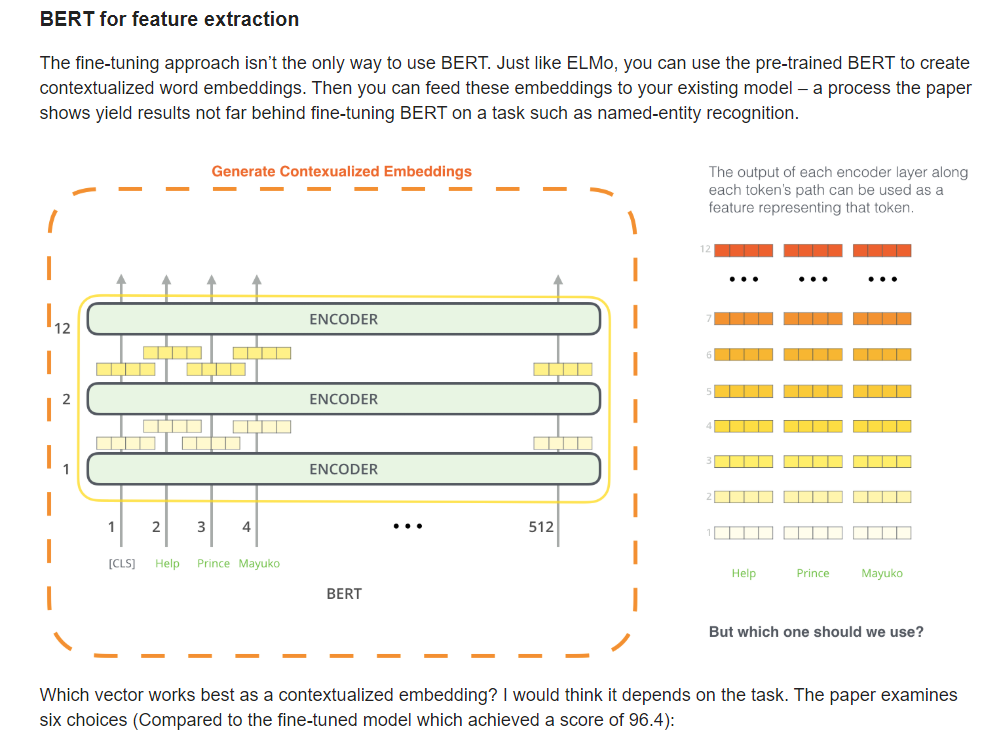

In [43]:
from IPython.display import Image
Image(filename='bert fine tuning.png')

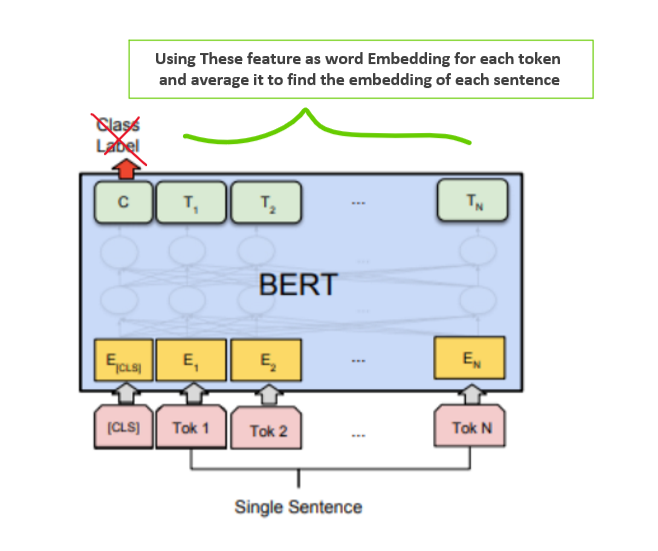

In [44]:
from IPython.display import Image
Image(filename='bert.png')

### 6.4.1. Finding AVG BERT Embedding

In [45]:
# Loading pretrained Model and Tokenizer

bert_model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

bert_model.cuda()
print("Model loaded on gpu.." )

Model loaded on gpu..


In [46]:
# function to find embeding of test using Bert
def bert_embedding_of_text(text,max_len = 128):
    
    # Step 1: Tokenize
    tokens = tokenizer.tokenize(text)

    # Step 2: Add [CLS] and [SEP]
    tokens = ['[CLS]'] + tokens + ['[SEP]']

    # Step 3.1: Pad tokens 
    if len(tokens) < max_len:
        padded_tokens = tokens + ['[PAD]' for _ in range(max_len - len(tokens))]
    else:
        padded_tokens = tokens[:max_len-1] + ['[SEP]']

    # Step 3.2: atttention mask
    attn_mask = [1 if token != '[PAD]' else 0 for token in padded_tokens]

    # Step 4: Segment ids
    seg_ids = [0 for _ in range(len(padded_tokens))] #Optional!

    # Step 5: Get BERT vocabulary index for each token
    token_ids = tokenizer.convert_tokens_to_ids(padded_tokens)
    
    
    ## Bert Embeddings of words except [cls] token 
    # Convert to pytorch tensors
    token_ids = torch.tensor(token_ids).unsqueeze(0).cuda()
    attn_mask = torch.tensor(attn_mask).unsqueeze(0).cuda()
    seg_ids = torch.tensor(seg_ids).unsqueeze(0).cuda()

    # Feed them to bert
    hidden_reps, cls_head = bert_model(token_ids, attention_mask = attn_mask,\
                                       token_type_ids = seg_ids)
    
    # Covert torch tensor to numpy array
    hidden_reps = hidden_reps.detach()
    
    return hidden_reps.squeeze()

#============================================================

# Function to find similarity using BERT avg Embedding using only 512 as max_len
def similarity_using_bert(text1, text2,max_length = 512):
    
    temp1 = bert_embedding_of_text(text1, max_length)
    temp2 = bert_embedding_of_text(text2, max_length)
    
    cos_sim = torch.nn.functional.cosine_similarity(temp1.mean(dim=1).unsqueeze(0) ,temp2.mean(dim=1).unsqueeze(0)) 
    
    return cos_sim.cpu().detach().numpy()[0]

### 6.4.2. Finding Similarity

In [47]:
# Finding similarity 

similarity_score_bert = []
for i in tqdm(range(data.shape[0])):
    
    sentence1 = data['text1'].iloc[i]
    sentence2 = data['text2'].iloc[i]  
    similarity_score_bert.append(similarity_using_bert(sentence1, sentence2, max_length = 512))
    
# Scaling the similarity between [0-1]
similarity_score_bert = minmax_scale(similarity_score_bert, feature_range=(0, 1))

# Round off upto 2 decimal
similarity_score_bert = np.round(similarity_score_bert, decimals=3)

100%|██████████████████████████████████████████████████████████████████████████████| 4023/4023 [04:58<00:00, 13.50it/s]


In [48]:
# Checking some similarity text
print(f"Index where similarity bestween text1 and text2 is greater than 0.9: {np.where(similarity_score_bert>0.8)[0]}")

print(f"Similarity Score of those index: {similarity_score_bert[np.where(similarity_score_bert>0.8)]}")

Index where similarity bestween text1 and text2 is greater than 0.9: [3403]
Similarity Score of those index: [1.]


In [49]:
# Sample of text where similarity score is greater than 0.90
i = 3403

print("Sample of text where similarity score is greater than 0.9\n\n")
print(f"text1: \n{'-'*7}\n{data.iloc[i].text1}\n")
print(f"text2: \n{'-'*7}\n{data.iloc[i].text2}\n")

Sample of text where similarity score is greater than 0.9


text1: 
-------
holmes starts 2005 with gb events kelly holmes will start 2005 with a series of races in britain.  holmes will make her first track appearance on home soil since winning double olympic gold in january s norwich union international in glasgow. she will also run in the grand prix in birmingham in february and may defend her indoor aaa 800m title in sheffield earlier that month.  i am still competitive and still want to win   she said.  i m an athlete and i can t wait to get back on the track.  she added:  these events are also a great opportunity to thank the british public for the enormous levels of support they have given me from the moment i stepped off that plane from greece.  the glasgow meeting will see holmes compete over 1500m in a five-way match against sweden  france  russia and italy.

text2: 
-------
holmes starts 2005 with gb events kelly holmes will start 2005 with a series of races in britain.  hol

## 7. Result And Conclusion

### 7.1. Saving Result

In [50]:
# Saving submission File
submission_w2v = pd.DataFrame({'Unique_ID':data.Unique_ID, 'similarity_score_w2v':similarity_score_w2v})
submission_w2v.to_csv(path_or_buf= 'submission_w2v.csv', sep=',',)

# Saving submission File
submission_tfidf_w2v = pd.DataFrame({'Unique_ID':data.Unique_ID, 'similarity_score_tfidf_w2v':similarity_score_tfidf_w2v})
submission_tfidf_w2v.to_csv(path_or_buf= 'submission_tfidf_w2v.csv', sep=',',)

# Saving submission File
submission_spacy = pd.DataFrame({'Unique_ID':data.Unique_ID, 'similarity_score_spacy':similarity_score_spacy})
submission_spacy.to_csv(path_or_buf= 'submission_spacy.csv', sep=',',)

# Saving submission File
submission_bert = pd.DataFrame({'Unique_ID':data.Unique_ID, 'similarity_score_bert':similarity_score_spacy})
submission_bert.to_csv(path_or_buf= 'submission_bert.csv', sep=',',)

### Conclusion

* These approaches are just some first cut solution to the problem.

* We can see using mentioned 4 approaches we are getting quite decent results; some approaches are obviously better than otheres because of better embeddings.

* TfIDF avg W2V has done really well to find the similarity scores.

* Results could be definitely improved using some addition techines like dimension reduction techniques and matrix factorisation techniques.

* Need to explore more "how to tackle unsupervised problem ? "

END :)